### This notebook computes the joint likelihood in 5 dimensions for the parameters of interest (see below). See inference_demo for more details about basic usage

In [1]:
from lenslikelihood.measurements import flux_measurements, flux_measurement_uncertainties, all_lens_names, all_param_ranges_version2
import numpy as np

# Note that the syntax for the uncertainties is
# {'lens_name': (1-sigma-uncertainty, reference_index, uncertainty_in_ratio)}
# where reference_index is the reference image with which to compute the flux ratio, and uncertainty_in_ratio specifies
# whether the measurement uncertainty refers to the flux or the flux ratio

for name in all_lens_names:
    print(name)
    print('fluxes/flux ratios measured: ', flux_measurements[name])
    print('uncertainties: ', flux_measurement_uncertainties[name])
    print('\n')

WGDJ0405
fluxes/flux ratios measured:  [0.8  0.52 1.   0.94]
uncertainties:  ([0.04, 0.061538461538461535, 0.024, 0.03418803418803419], 0, False)


HE0435
fluxes/flux ratios measured:  [0.96  0.976 1.    0.65 ]
uncertainties:  ([0.05, 0.049, 0.048, 0.056], 0, False)


WGD2038
fluxes/flux ratios measured:  [0.86 1.   0.79 0.4 ]
uncertainties:  ([0.01, 0.01724137931034483, 0.021739130434782608, 0.021739130434782608], 0, False)


B1422
fluxes/flux ratios measured:  [0.88  1.    0.474 0.025]
uncertainties:  ([0.011363636363636364, 0.01, 0.012765957446808512, None], 0, False)


WFI2033
fluxes/flux ratios measured:  [1.   0.65 0.5  0.53]
uncertainties:  ([0.03, 0.046875, 0.04, 0.03773584905660377], 0, False)


PSJ1606
fluxes/flux ratios measured:  [1.   1.   0.59 0.79]
uncertainties:  ([0.03, 0.03, 0.03333333333333333, 0.02564102564102564], 0, False)


WFI2026
fluxes/flux ratios measured:  [1.   0.75 0.31 0.28]
uncertainties:  ([0.02, 0.02666666666666667, 0.06451612903225806, 0.0357142857142

### Models implemented for the halo mass function and concentration-mass relation

The full set of hyper-parameters we're interested in constraining are defined by the parameterizations of the halo mass function and concentration-mass relation. They are $\Sigma_{\rm{sub}}$, $\delta_{\rm{LOS}}$, $\Delta \alpha$, $q$, $c_8$, and $\beta$. The first four define to the subhalo and field halo mass functions, and the last two define the concentration-mass relation. 

The field halo mass function is parameterized as
\begin{equation}
\frac{dN_{\rm{LOS}}}{dm dV} = \delta_{\rm{LOS}} \left(1+\xi_{\rm{2halo}}\right) \left(\frac{m}{10^8}\right)^{\Delta \alpha} \ \frac{dN_{\rm{ShethTormen}}}{dm dV}
\end{equation}
where $\delta_{\rm{LOS}}$ scales the overall normalization, and $\Delta \alpha$ parameterizes deviations from the logarithmic slope predicted by CDM around $10^8 M_{\odot}$. 

The subhalo mass function is parameterized as
\begin{equation}
\frac{dN_{\rm{sub}}}{dm dA} \sim \Sigma_{\rm{sub}} \ \left(\frac{m}{10^8}\right)^{\alpha + q \Delta \alpha}
\end{equation}
where $\Sigma_{\rm{sub}}$ is the normalization, $\alpha$ is the logarithmic slope predicted by CDM, $\Delta \alpha$ parameterizes deviations from the value predicted by CDM, and $q$ controls the coupling between the line of sight halo mass function slope and the subhalo mass function slope. When $q=1$ the slopes change in the same way, and when $q=0$ the slopes of the subhalo and field halo mass functions are completely decoupled. 

The concentration-mass relation is parameterized as 

\begin{equation}
c\left(M, z\right) = c_8 \left(1+z\right)^{\zeta} \left(\frac{\nu\left(M, z\right)}{\nu\left(10^8, z\right)}\right)^{-\beta}
\end{equation}
i.e. it is a power-law in the peak height $\nu$ with normalization $c_8$ at $10^8$ and a logarithmic slope $\beta$. The parameter $\zeta$ modifies the redshift evolution and is marginalized over in the sampling. 

The parameter names used in the python code have the following correspondence: 


1) sigma_sub = $\Sigma_{\rm{sub}}$

2) delta_power_law_index = $\Delta \alpha$

3) c0 = $c_8$

4) beta = $\beta$

5) delta_power_law_index_coupling = $q$

6) LOS_normalization = $\delta_{\rm{LOS}}$

### Example inference on three parameters with a subset of lenses

First load the model samples, define what parameters we want to look at

In [2]:
import pickle
import matplotlib.pyplot as plt
# specify the parameter names
param_names = ['LOS_normalization', 'beta', 'log10c0', 'delta_power_law_index', 'sigma_sub']
param_ranges = [all_param_ranges_version2[name] for name in param_names]
print(param_ranges)
# specify the lenses to use
lenses = all_lens_names
raw_samples_dict = {}
# load the forward model samples
for lens in lenses:
    print(lens)
    f = open('./../raw_samples/'+lens+'_logprior', 'rb')
    raw_samples = pickle.load(f)
    f.close()
    raw_samples_dict[lens] = raw_samples 

[[0.0, 2.0], [-0.2, 15.0], [0, 4], [-0.6, 0.9], [0, 0.1]]
WGDJ0405
HE0435
WGD2038
B1422
WFI2033
PSJ1606
WFI2026
RXJ0911
RXJ1131
MG0414
PG1115


The next cell computes the joint likelihood without any importance sampling weights.

working on lens WGDJ0405... 
working on lens HE0435... 
working on lens WGD2038... 
working on lens B1422... 
working on lens WFI2033... 
working on lens PSJ1606... 
working on lens WFI2026... 
working on lens RXJ0911... 
working on lens RXJ1131... 
working on lens MG0414... 
working on lens PG1115... 


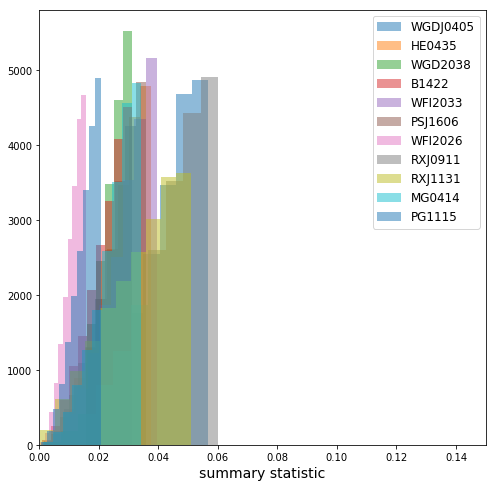

In [4]:
# compute the summary statistics, retaining the 1500 sets of model parameters with lowest summary statistic
n_samples_keep = 2000
samples_dict = {}
fig = plt.figure(1)
fig.set_size_inches(8,8)
for lens in lenses:
    print('working on lens '+str(lens) + '... ')
    measured_fluxes = flux_measurements[lens]
    measurement_uncertainties = flux_measurement_uncertainties[lens][0]
    reference_index = flux_measurement_uncertainties[lens][1]
    uncertaintiy_in_flux_ratios = flux_measurement_uncertainties[lens][2]
    importance_sampling_weights = None
    
    samples, full_samples, statistic = raw_samples_dict[lens].sample_with_abc(measured_fluxes, 
                                                                   param_names, 
                                                                   measurement_uncertainties, 
                                                                   reference_index, 
                                                                   n_samples_keep,  
                                                                n_draw=10,
                                                                   uncertaintiy_in_ratios=uncertaintiy_in_flux_ratios,
                                                                   importance_sampling_weights=importance_sampling_weights)
    plt.hist(statistic, alpha=0.5, label=lens)
    samples_dict[lens] = samples

# the histogram shows the distribution of the retained summary statistics
plt.legend(fontsize=12)
plt.xlim(0., 0.15)
plt.xlabel('summary statistic', fontsize=14)
plt.show()

Now we compute the likelihood using the package trikde https://github.com/dangilman/trikde

In [5]:
from trikde.pdfs import DensitySamples, IndepdendentLikelihoods
import os

nbins = 20
likelihoods = []

load_from_pickle = False # if True, will look for a pre-computed DensitySamples class
save_to_pickle = True # if True, will pickle each class for accelerated later use; 
# save_to_pickle=True will do nothing if load_from_pickle=True

filename_extension = '_joint_logprior'
base_path = './../lenslikelihood/precomputed_likelihoods/'

for lens in all_lens_names:
    
    fname = base_path + lens + filename_extension
    if load_from_pickle and os.path.exists(fname):
        print('loading joint likelihoods for lens '+lens+' ...')
        f = open(fname, 'rb')
        single_lens_likelihood = pickle.load(f)
        f.close()
    else:
        print('computing joint likelihoods for lens '+lens+' ...')
        lens_samples = samples_dict[lens]
        weights=None
        single_lens_likelihood = DensitySamples(lens_samples, param_names, weights, 
                                 param_ranges, nbins=nbins, use_kde=True, bandwidth_scale=0.9)
        if save_to_pickle:
            f = open(fname, 'wb')
            pickle.dump(single_lens_likelihood, f)
            f.close()
    likelihoods.append(single_lens_likelihood)
    
likelihood = IndepdendentLikelihoods(likelihoods)

computing joint likelihoods for lens WGDJ0405 ...
computing joint likelihoods for lens HE0435 ...
computing joint likelihoods for lens WGD2038 ...
computing joint likelihoods for lens B1422 ...
computing joint likelihoods for lens WFI2033 ...
computing joint likelihoods for lens PSJ1606 ...
computing joint likelihoods for lens WFI2026 ...
computing joint likelihoods for lens RXJ0911 ...
computing joint likelihoods for lens RXJ1131 ...
computing joint likelihoods for lens MG0414 ...
computing joint likelihoods for lens PG1115 ...


### The joint likelihood/posterior with no modeling assumptions (indepedent, uniform priors on all model parameters). 

[[0.0, 2.0], [-0.2, 15.0], [0, 4], [-0.6, 0.9], [0, 0.1]]


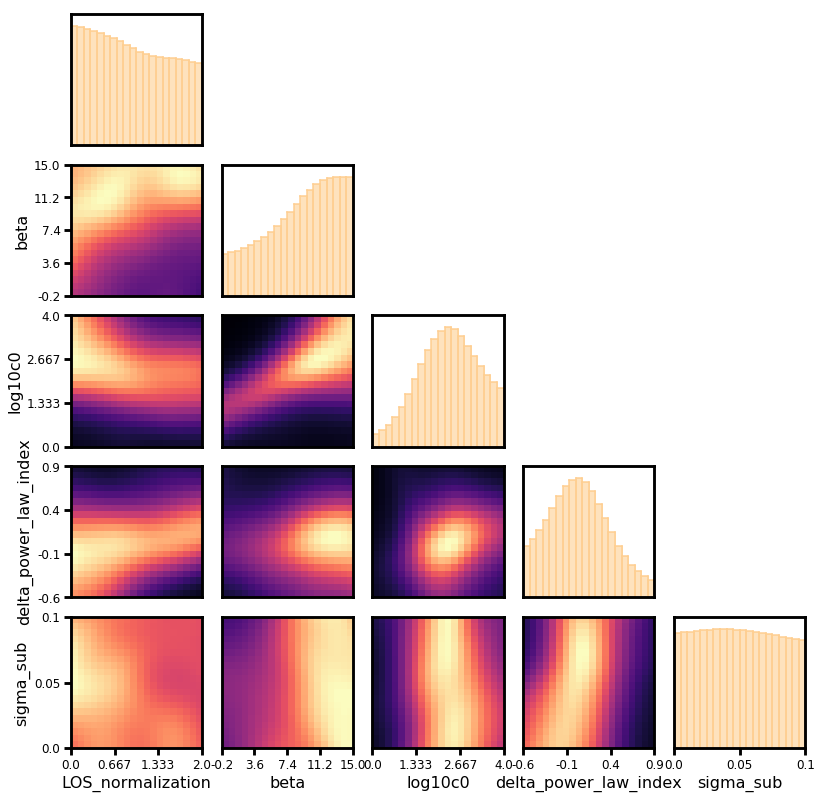

In [6]:
from trikde.triangleplot import TrianglePlot
print(param_ranges)
triangle_plot = TrianglePlot([likelihood])
triangle_plot.set_cmap('magma')
axes = triangle_plot.make_triplot(filled_contours=False, show_intervals=False, show_contours=False
                                 )
# can change axis labels

In [7]:
from trikde.pdfs import CustomPriorHyperCube

def couple_mass_functions(samples, sigma_sub_theory=0.05, coupling_strength=0.05):
    
    delta_los_samples = samples[:, 0]
    sigma_sub_samples = samples[:, -1]
    delta_sigma_sub = sigma_sub_samples/sigma_sub_theory
    chi2 = (delta_sigma_sub - delta_los_samples)**2/coupling_strength**2 
    return chi2

kwargs_1 = {'sigma_sub_theory': 0.05}
kwargs_2 = {'sigma_sub_theory': 0.025}
prior_on_mass_functions_1 = CustomPriorHyperCube(couple_mass_functions, param_names, param_ranges, nbins, kwargs_1)
prior_on_mass_functions_2 = CustomPriorHyperCube(couple_mass_functions, param_names, param_ranges, nbins, kwargs_2)

likelihoods_coupled_with_prior_mass_functions = likelihoods + [prior_on_mass_functions_1]
likelihood_coupled_with_prior_mass_functions_1 = IndepdendentLikelihoods(likelihoods_coupled_with_prior_mass_functions)
likelihoods_coupled_with_prior_mass_functions = likelihoods + [prior_on_mass_functions_2]
likelihood_coupled_with_prior_mass_functions_2 = IndepdendentLikelihoods(likelihoods_coupled_with_prior_mass_functions)

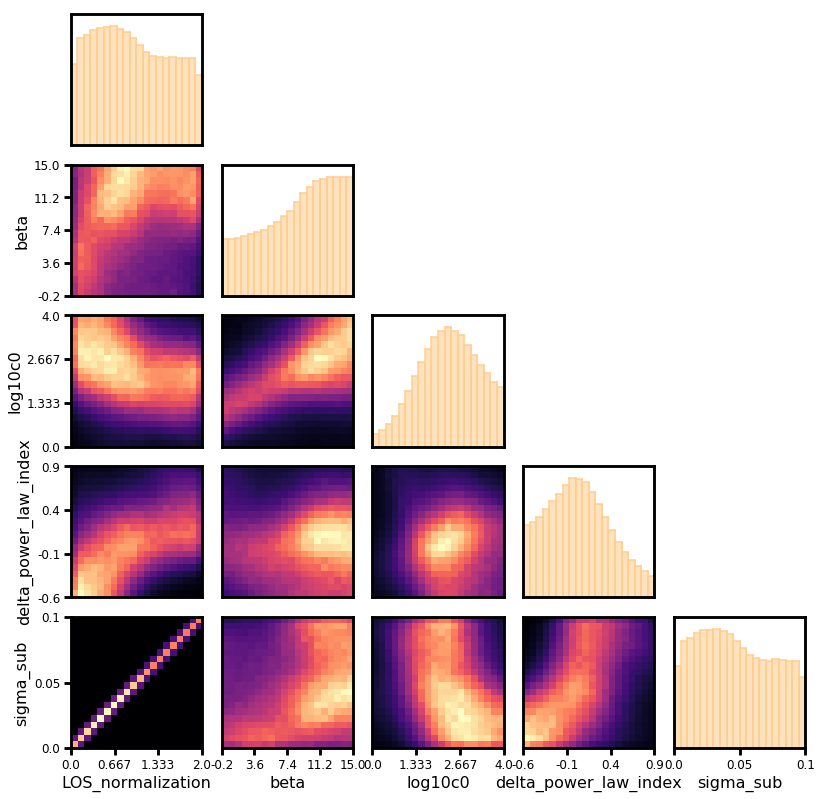

In [8]:
triangle_plot = TrianglePlot([likelihood_coupled_with_prior_mass_functions_1])
triangle_plot.set_cmap('magma')
axes = triangle_plot.make_triplot(filled_contours=False, show_intervals=False, show_contours=False
                                 )